<!-- Simon-Style -->
<p style="font-size:19px; text-align:left; margin-top:    15px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Use Case SOA GLTD Experience Study:<br>
Permutation Feature Importance </b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 15px">Guido Grützner (<a href="mailto:guido.gruetzner@quantakt.com">guido.gruetzner@quantakt.com</a>)

# Introduction

This notebook calculates the explainability statistics "permutation feature importance"(PFI) from Scikit-learn for the three models Tree, GLM and GBT. We are not so much interested in the absolute importance values but in the relative ranking of the inputs. In many applications, variable importance statistics are presented for a fitted model, as if they were a fixed number. Here, instead, we try to reflect the various sources of uncertainty around these statistics. Those are:
* Randomness of the sample for the underlying data, reflected in several runs on a sample of the available data, i.e. a bootstrap.
* Randomness of the fitted model, due to the underlying sample, as well as potential inherent randomness in the fit procedure. Reflected by repeatedly fitting a new model on each bootstrapped sample.
* Randomness of the estimate of the importance statistic, reflected by iteratively calculating the statistics. The estimator for PFI is particularly noisy, which is appreciated in Scikit-learn by providing a parameter `n_repeats` which, as the name implies, repeats the estimation on independent permutations and reports the average.  

In each run, all models will be fit on the same sample and their PFI estimates are always computed with common random numbers. This minimizes random differences between models' PFI estimates within each run, while still maintaining independence between runs. 

All this sampling is a considerable strain on computational resources. The current parameter settings are a compromise between precision and time required to run the notebook. The chosen parameters are:
* pct=0.3
* Bootstrapping with subsets of 70% of the available data. 
* 5 repetitions of the permutations to calculate PFI.

More conservative values (i.e. larger pct with smaller overlap in resampling and more repetitions) may or may not lead to even larger ranges for the observed rankings. 

**As is, this notebook takes roughly 200 min to run**.

# Remark on One Hot Encoding (OHE)

In contrast to the GLM and the GBT model, Trees in Scikit-learn require explicit OHE. This raises the general issue on how to treat OHE encoding in variable importance explanations. The basic questions immediately arising are 
* Should I calculate and show variable importance for OHE encoded variables?
* If so, is there a way to transform the importance of the encoded variables to arrive at an importance for the underlying category which is encoded?
* If not, how do I get around calculating importance for OHE variables in the first place?

The author of this notebook thinks that it makes no sense in general to show importance of encoded levels, and advises strongly against it. There are several reasons for this recommendation. 

**Invariance under encoding rules**
Given any categorical variable with more than two categories, there are many ways to encode it. For example, drop first (by what order?), drop last, or don't drop at all. There are even non OHE encoding schemes, such as sum to zero or orthogonal contrasts. Each encoding scheme will produce different variable importance measures. This can be seen easily for the example of "drop first". The first level (in whatever order) will receive no importance value. Does this mean this category is not important? Encoding schemes are arbitrary, and, if your variable importance values depend on the encoding scheme, these values will be arbitrary as well.

**Dependence between OHE variables**
OHE variables are never stochastically independent. If you have three categories for age, say "young", "middle" and "old", and if young=1 then middle and old have to be zero. But many estimates of importance measures use independent(!) permutations of inputs. This means you will happily average over model outputs generated by data with young=1 AND old=1. This is an extreme case of impossible data and will most likely make no sense at all. 

**Difficulty in interpretation**
This dependence makes the importance of single categories difficult to interpret. Take a typical application as an example. Typically, if a variable is not important, you may want to exclude it from further consideration. What does it mean to exclude a single category from consideration? If you drop a category, all other categories need to be adjusted. In the age example, if you drop "middle" you would need to adjust your definition of "young" and "old".

**Summary and comparison**
Either because your business case or your audience demand it, or if you would like to compare results with non-OHE models, ultimately you will want to provide an importance measure for the categorical variable as a total. But it is by no means clear whether simply adding up importance values for the OHE variables is meaningful. Many importance measures are not additive allocations, but provide values which are normalised to 100%. In these case adding up values makes no sense. So you need to come up with an aggregation rule, which makes sense and is invariant under the arbitrary encoding scheme.

**Practical considerations**
The GLTD dataset has 14 categorical variables. If you do OHE with drop first for all of them, you will have 155 variables to discuss.   

So, if it is not a good idea, how can one avoid variable importance for OHE variables? It is actually quite easy and shown in this notebook. The trick is to "hide" the OHE from the importance procedure, by encapsulating the OHE together with the model in a pipeline. See the second code block in the section "Technical preparations". This same trick will work for all blackbox explanation methods. On the other hand, this approach is not possible for model specific methods. For trees, this would be the impurity based measure returned by Scikit's ``DecisionTreeClassifier`` in the property `feature_importances_
`. For this reason, and because it is a problematic method anyway (see [Scikit's comment on this](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#tree-s-feature-importance-from-mean-decrease-in-impurity-mdi)), this method is not used for this use case.       


# Initialisation

In [1]:
from glum import GeneralizedLinearRegressor
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GroupShuffleSplit

from sklearn.inspection import permutation_importance
from scipy.stats import rankdata

import matplotlib.pyplot as plt
# adjust according to your age and vision
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 15   # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick label font size 


import gltd_utilities

import warnings
import time
import pickle
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

# adjust accordingly, more CPUs is faster but then script may block PC
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

To run the notebook

* Adapt the path for the data file in the call of `load_gltd_data`, if necessary.
* Adapt pct to your requirements for anything between  $0.05\leq pct\leq1$. 
* Input 1 uses all data available, lower numbers the respective fraction. Below 0.05 predictions become somehwat volatile.

In [2]:
tic = time.time()
path_to_data = "./"
(X, Y, ID, nm_cat, nm_num, seed, rng) = gltd_utilities.load_gltd_data(
                                            path_to_data, pct=0.3)
seed

'155544822531331570652269154776789623993'

In [3]:
# file for cached bootstrap
cachefile = path_to_data + "cache_pfi.pkl"

# Technical preparations

In [4]:
# For GLUM

# Input variables to use
allvars = nm_cat + nm_num

# Formula for main effects
ttlist = [var for var in allvars]

# # Choose this formula for semi-parametric model with splines on the numerical 
# # variables
# ttlist = [var if (var in nm_cat) 
#             else "bs(" + var + ", df=5, degree=3, extrapolation='extend')" 
#         for var in allvars]

fml = "~ " + "+".join(ttlist)

# We need a wrapper for GLUM since permutation_importance requires a method
# called predict_proba with two columns but glum only offers predict.
class WrappedGlum(ClassifierMixin, BaseEstimator):
    def __init__(self, model):
        self.model = model
        self.classes_ = np.array([0,1])

    def fit(self, X, Y):
        self.model.fit(X, Y)
        return self

    def predict_proba(self, X):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            p = np.array(self.model.predict(X))
            
        return np.column_stack([1-p, p])
    
    def __getattr__(self, name):
        return getattr(self.model, name)

In [5]:
# For Tree

# The pipeline below is required to hid the OHE encoding from the PFI procedure.  

# we need all possible levels to avoid unknown levels
# in test after split and train.
alllevels = [sorted(X[col].unique().tolist()) for col in nm_cat]

ohe_coding = ColumnTransformer(
    [("", OneHotEncoder(
            drop="first",
            dtype=int,
            sparse_output=False, 
            categories=alllevels),
        nm_cat)],
    remainder="passthrough", verbose_feature_names_out=False)

rf = Pipeline(
    [   ("preprocess", ohe_coding),
        ("classifier", DecisionTreeClassifier(
                        random_state=rng.integers(low=0, high=1000),
                        max_depth=7, 
                        criterion="log_loss"
                        ))
    ]
)

# Permutation Feature Importance

In [6]:
# Check for cache
if os.path.exists(cachefile):
    with open(cachefile, 'rb') as f:
        cachedata = pickle.load(f)
    
    nm_method = cachedata["nm_method"]
    sammler = cachedata["sammler"]
    nsplit = cachedata["nsplit"]

else:
    # Set up bootstrap splits
    gss = GroupShuffleSplit(n_splits=30, train_size=0.7,
                            random_state=rng.integers(low=0, high=1000))
    nsplit = gss.get_n_splits()

    sammler = {"GLM": list(), "Tree": list(), "GBT": list()}
    mdict = {}
    nm_method = list(sammler)

    for ii, (trainidx, testidx) in enumerate(gss.split(X, groups=ID)):
        print("--------------------------------------------")
        print(f"Run {ii + 1}:")
        print("--------------------------------------------")

        xtrain, xtest = X.iloc[trainidx, :], X.iloc[testidx, :]
        ytrain, ytest = Y.iloc[trainidx], Y.iloc[testidx]

        # GLUM 
        md = GeneralizedLinearRegressor(
            l1_ratio=0.0,
            alpha=1e-6,
            family="binomial", 
            link="logit",
            fit_intercept=True,
            drop_first=True,
            formula = fml
        )    
        wmd = WrappedGlum(md)            
        wmd.fit(xtrain, ytrain)
        mdict["GLM"] = wmd

        #Tree
        rf.fit(xtrain, ytrain)
        mdict["Tree"] = rf

        #GBT
        md = HistGradientBoostingClassifier(
            interaction_cst = None,
            categorical_features="from_dtype",
            max_iter=1000,
            learning_rate=0.025,
            max_leaf_nodes=100,
            random_state=rng.integers(low=0, high=1000))
        md.fit(xtrain, ytrain)
        mdict["GBT"] = md

        # Fix seed so that each PFI calc is on common random numbers
        rndseed = rng.integers(low=0, high=1000)

        for nm, md in mdict.items():
            sammler[nm].append([permutation_importance(md, 
                        xtest, ytest,
                        n_repeats=5,
                        scoring=["neg_log_loss"],
                        random_state=rndseed)["neg_log_loss"]["importances_mean"]
        ])
            
    # write results of bootstrap to disk
    cachedata = {"nm_method": nm_method, "sammler": sammler, "nsplit": nsplit}

    with open(cachefile, 'wb') as f:
            pickle.dump(cachedata, f)

--------------------------------------------
Run 1:
--------------------------------------------
--------------------------------------------
Run 2:
--------------------------------------------
--------------------------------------------
Run 3:
--------------------------------------------
--------------------------------------------
Run 4:
--------------------------------------------
--------------------------------------------
Run 5:
--------------------------------------------
--------------------------------------------
Run 6:
--------------------------------------------
--------------------------------------------
Run 7:
--------------------------------------------
--------------------------------------------
Run 8:
--------------------------------------------
--------------------------------------------
Run 9:
--------------------------------------------
--------------------------------------------
Run 10:
--------------------------------------------
-----------------------------

# Graphics

In [40]:
nvar = xtest.shape[1]
nm_var = xtest.columns
rank_dict = {meth: None for meth in nm_method}

for meth, vi in sammler.items():
    tmparr = np.array(vi).reshape(nsplit, nvar).T
    tmp = 1 + nvar - np.apply_along_axis(rankdata, 0, tmparr)
    rank_dict[meth] = pd.DataFrame(tmp, index=nm_var)

def helper_display(meth, vi):
    
    hilist = np.max(vi, axis=1)
    lolist = np.min(vi, axis=1)

    lims = [(lo, hi) for lo, hi in zip(lolist, hilist)]

    fig, ax = plt.subplots(figsize = (7,5))
    ax.set_yticks([])
    ax.set_xlim([1, np.max(hilist)+1])
    ax.grid(which="major", axis="x")
    ax.set_xticks([1,5,10,15,20, nvar + 1])
    
    tmp = nvar - 1
    for i, (start, end) in enumerate(lims):
        ax.plot([start, end],  [i, i], marker='o')
        ax.plot([1, tmp+1],  [i, i], color="black", lw=0.1)
        ax.text(nvar + 2, i, nm_var[i].strip())

    ax.set_xlabel("Rank (lower is more important)")    
    # Remove bounding box (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title("Bootstrapped ranks " + meth)
    plt.show()

Recall that, for each run, PFI is calculated for each input variable. This provides an importance ranking for the input variables in a run. After several repeated runs, with repeated rankings, we show below for each input the lowest (left) and highest (right) rank attained.

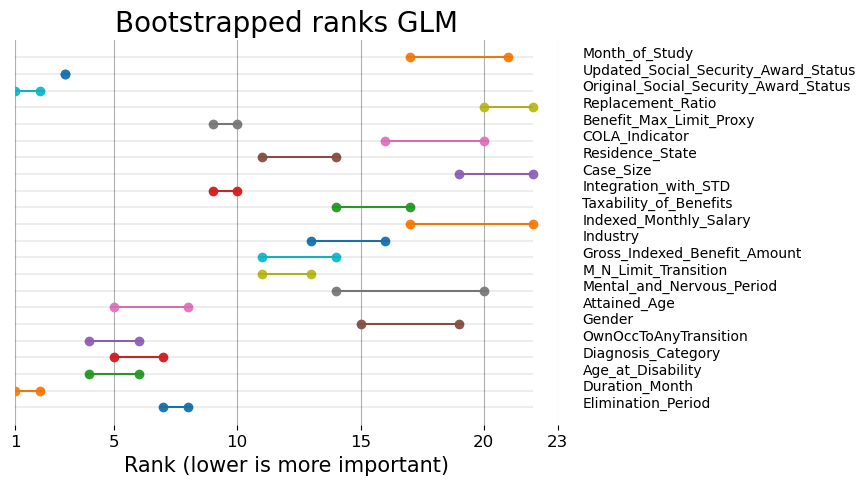

In [41]:
it = iter(rank_dict.items())
(meth, vi) = next(it)
helper_display(meth, vi)

There are only three consistently and top ranked variables:
* Original_Social_Security_Award_Status
* Updated_Social_Security_Award_Status
* Duration_Month

The remaining inputs are less consistently ranked. Many are smeared over three or more ranks.

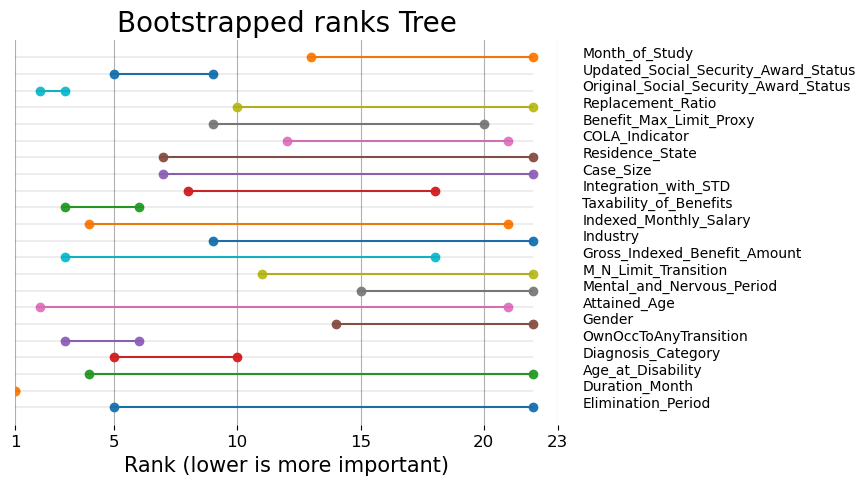

In [37]:
(meth, vi) = next(it)
helper_display(meth, vi)

The picture for tree is much more fuzzy than for GLM and GBT. Only two top inputs are (more or less) consistently ranked. The variable Taxability_of_Benefits, comes in third. Ranks for other inputs are all over the place. One may say that there is no consistent measure of importance for these variables. This is all the more surprising, since the tree's predictive quality and its variance are quite comparable to the other models.    

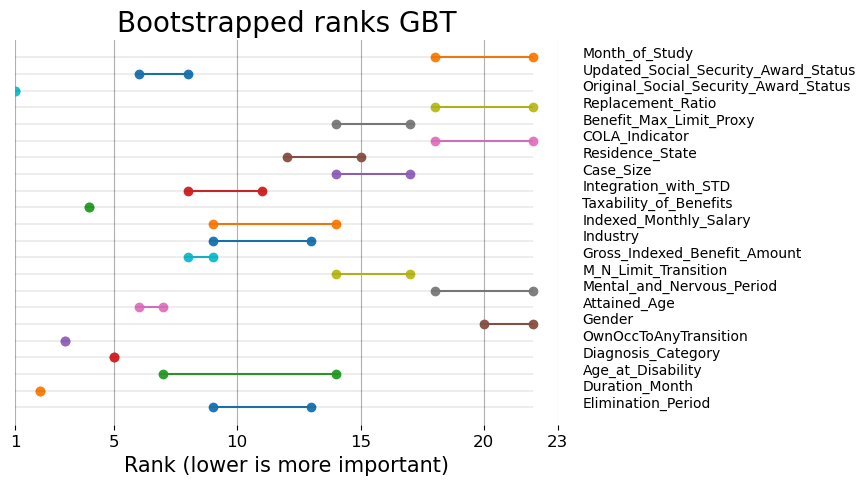

In [20]:
(meth, vi) = next(it)
helper_display(meth, vi)

The GBT results are the most consistent ones. Five variables are top ranked. The spread for the other inputs is quite similar to GLM. Attained_Age and Gross_Indexed_Benefit_Amount, both variables which are often considered important in actuarial analysis, feature more prominently than for the GLM.

In [11]:
print(f"Time it took: {np.ceil((time.time() - tic)/60)}min.")

Time it took: 475.0min.
